## Импорт зависимостей

In [1]:
!pip install medcam3d grad-cam -q

In [2]:
import os
import re
import torch
import torchvision
import pandas as pd
from torch import nn, optim
from transformers import GPT2Tokenizer, GPT2LMHeadModel, BertTokenizer, BertForSequenceClassification
from pytorch_grad_cam import GradCAM
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit

## Загрузка и предобработка данных

In [3]:
rpt = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')
proj = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

In [4]:
df = proj.merge(rpt, on='uid', how='left')
df = df.dropna(subset=['findings','impression'])
df['report'] = df['findings'].fillna('') + ' ' + df['impression'].fillna('')

In [5]:
df["path"] = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized/' + df["filename"]

In [6]:
df.head()

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,report,path
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,The cardiac silhouette and mediastinum size ar...,/kaggle/input/chest-xrays-indiana-university/i...
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,The cardiac silhouette and mediastinum size ar...,/kaggle/input/chest-xrays-indiana-university/i...
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,Borderline cardiomegaly. Midline sternotomy XX...,/kaggle/input/chest-xrays-indiana-university/i...
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,Borderline cardiomegaly. Midline sternotomy XX...,/kaggle/input/chest-xrays-indiana-university/i...
6,4,4_IM-2050-1001.dcm.png,Frontal,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...,There are diffuse bilateral interstitial and a...,/kaggle/input/chest-xrays-indiana-university/i...


Разбиение на выборки

In [7]:
split = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(split.split(df, groups=df['uid']))
train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

In [8]:
train_df.shape, test_df.shape

((5164, 12), (1293, 12))

### Парсинг MeSH → pathology теги

In [9]:
common_labels = [
    "atelectasis","cardiomegaly","consolidation","edema","pleural effusion",
    "pneumonia","pneumothorax","support devices","enlarged cardiomediastinum",
    "fracture","lung lesion","lung opacity","pleural other","pleural thickening", "normal"
]
label_map = {lbl: i for i,lbl in enumerate(common_labels)}

Построение label_map

In [10]:
def extract_labels(mesh_str):
    tags = []
    for term in re.split('[;/]', mesh_str.lower()):
        term = term.strip()
        for lbl in common_labels:
            if lbl in term:
                tags.append(lbl)
    return list(set(tags))


In [11]:
# df_labels = df[['uid','MeSH']].dropna()
df_labels = df[['uid','MeSH']].drop_duplicates().copy()

df_labels['labels'] = df_labels['MeSH'].apply(extract_labels)

mlb = MultiLabelBinarizer(classes=common_labels)
mlb.fit([common_labels])

MultiLabelBinarizer(classes=['atelectasis', 'cardiomegaly', 'consolidation',
                             'edema', 'pleural effusion', 'pneumonia',
                             'pneumothorax', 'support devices',
                             'enlarged cardiomediastinum', 'fracture',
                             'lung lesion', 'lung opacity', 'pleural other',
                             'pleural thickening', 'normal'])

In [12]:
label_map = {}
for uid, grp in df_labels.groupby('uid'):
    lbls = grp['labels'].sum()  # объединяем списки (хотя обычно один элемент)
    vect = mlb.transform([lbls])[0]
    label_map[uid] = torch.tensor(vect, dtype=torch.float)

In [13]:
# Проверяем, что есть метки для каждой группы:
miss = set(train_df['uid']) - set(label_map.keys())
print("UIDs without labels:", miss)
assert not miss, "Проверьте функцию extract_labels: не все UID получили метки"

UIDs without labels: set()


### DataLoader с фронтальными и латеральными проекциями

In [14]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

In [15]:
class IUDataset(Dataset):
    def __init__(self, df, img_dir, label_map, transform=None):
        self.transform = transform
        self.groups = df.groupby('uid')
        self.uids = list(self.groups.groups.keys())
        self.img_dir = img_dir
        self.label_map = label_map

    def __len__(self):
        return len(self.uids)

    def __getitem__(self, idx):
        uid = self.uids[idx]
        group = self.groups.get_group(uid)
        # выбираем frontal
        if 'projection' in group.columns and 'frontal' in group['projection'].values:
            row = group[group['projection']=='frontal'].iloc[0]
        else:
            row = group.iloc[0]

        path = row['path']  # убедитесь, что колонка называется именно так
        image = Image.open(os.path.join(self.img_dir, path)).convert('RGB')
        if self.transform:
            image = self.transform(image)

        labels = self.label_map[uid]        # теперь это dict, а не Compose
        report = row['report']

        return {'img_f': image, 'report': report, 'labels': labels}


In [16]:
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [17]:
train_ds = IUDataset(train_df, '/kaggle/input/chest-xrays-indiana-university/images/images_normalized', transform=tfm, label_map=label_map)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2)

test_ds = IUDataset(test_df, '/kaggle/input/chest-xrays-indiana-university/images/images_normalized', transform=tfm, label_map=label_map)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True, num_workers=2)

## Определение DenseTagger (CheXNet‑backbone)

In [18]:
class DenseTagger(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.backbone = torchvision.models.densenet121(pretrained=True)
        # Заменяем классификатор на multi-label
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Linear(in_features, num_labels)

    def forward(self, x):
        # x: [batch, 3, H, W]
        logits = self.backbone(x)
        return logits  # BCEWithLogitsLoss применит sigmoid внутри

In [19]:
# Гиперпараметры
num_labels = 15  # Число патологий в IU X-Ray (настройте по CSV)
batch_size = 16
lr = 1e-4
num_epochs = 5

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Инициализация модели, loss и оптимизатора
model = DenseTagger(num_labels=num_labels).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
def train_epoch(model, loader, criterion, optimizer):
    """
    Обучение модели
    """
    model.train()
    total_loss = 0.0
    for batch in loader:
        imgs = batch['img_f'].to(device)  # используем frontal view
        # Если нужны оба вида: concat или два потока
        targets = batch['labels'].to(device)  # tensor [B, num_labels]

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

In [23]:
def validate_epoch(model, loader, criterion):
    """
    Валидация модели
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            imgs = batch['img_f'].to(device)
            targets = batch['labels'].to(device)
            logits = model(imgs)
            loss = criterion(logits, targets)
            total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

## Обучение с сохранением наилучшего чекпоинта по минимальной валидационной потере

In [24]:
best_val = float('inf')
best_epoch = -1

In [25]:
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_dl, criterion, optimizer)
    val_loss = validate_epoch(model, test_dl, criterion)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val:
        best_val = val_loss
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss
        }, 'best_dense_tagger.pt')
        print(f"=> New best model saved (epoch {epoch}, val_loss={val_loss:.4f})")

print(f"Training complete. Best val_loss {best_val:.4f} at epoch {best_epoch}")

Epoch 1: Train Loss = 0.1908, Val Loss = 0.1067
=> New best model saved (epoch 1, val_loss=0.1067)
Epoch 2: Train Loss = 0.0864, Val Loss = 0.1100
Epoch 3: Train Loss = 0.0667, Val Loss = 0.1055
=> New best model saved (epoch 3, val_loss=0.1055)
Epoch 4: Train Loss = 0.0460, Val Loss = 0.1145
Epoch 5: Train Loss = 0.0310, Val Loss = 0.1271
Training complete. Best val_loss 0.1055 at epoch 3


Загрузка наилучшей модели

In [26]:
ckpt = torch.load('best_dense_tagger.pt')
model.load_state_dict(ckpt['model_state_dict'])
optimizer.load_state_dict(ckpt['optimizer_state_dict'])
print(f"Loaded best model from epoch {ckpt['epoch']} with val_loss = {ckpt['val_loss']:.4f}")

Loaded best model from epoch 3 with val_loss = 0.1055


In [30]:
# model.eval()
# with torch.no_grad():
#     batch = next(iter(test_dl))
#     imgs = batch['img_f'].to(device)
#     logits = model(imgs)               # [B,14]
#     probs = torch.sigmoid(logits)      # вероятности
#     preds = (probs > 0.5).int()        # бинарные метки

# print("Probs:\n", probs.cpu().numpy())
# print("Preds:\n", preds.cpu().numpy())
# print("GT:\n", batch['labels'].cpu().numpy())

In [28]:
model.eval()
with torch.no_grad():
    batch = next(iter(test_dl))
    imgs = batch['img_f'].to(device)
    probs = torch.sigmoid(model(imgs)).cpu().numpy()
    preds = (probs > 0.5).astype(int)

for i in range(len(imgs)):
    print(f"=== Sample {i} ===")
    print("Probabilities:", {common_labels[j]: round(float(probs[i,j]), 3) for j in range(len(common_labels))})
    print("Predicted:", [common_labels[j] for j in range(len(common_labels)) if preds[i,j] == 1])
    print("Ground‑Truth:", [common_labels[j] for j in range(len(common_labels)) if batch['labels'][i,j] == 1])
    print()

=== Sample 0 ===
Probabilities: {'atelectasis': 0.009, 'cardiomegaly': 0.012, 'consolidation': 0.003, 'edema': 0.006, 'pleural effusion': 0.002, 'pneumonia': 0.002, 'pneumothorax': 0.003, 'support devices': 0.001, 'enlarged cardiomediastinum': 0.001, 'fracture': 0.004, 'lung lesion': 0.002, 'lung opacity': 0.003, 'pleural other': 0.004, 'pleural thickening': 0.004, 'normal': 0.904}
Predicted: ['normal']
Ground‑Truth: ['normal']

=== Sample 1 ===
Probabilities: {'atelectasis': 0.017, 'cardiomegaly': 0.004, 'consolidation': 0.002, 'edema': 0.005, 'pleural effusion': 0.004, 'pneumonia': 0.004, 'pneumothorax': 0.007, 'support devices': 0.004, 'enlarged cardiomediastinum': 0.002, 'fracture': 0.017, 'lung lesion': 0.003, 'lung opacity': 0.006, 'pleural other': 0.004, 'pleural thickening': 0.004, 'normal': 0.593}
Predicted: ['normal']
Ground‑Truth: []

=== Sample 2 ===
Probabilities: {'atelectasis': 0.008, 'cardiomegaly': 0.031, 'consolidation': 0.005, 'edema': 0.011, 'pleural effusion': 0.00

In [29]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_dl:
        probs = torch.sigmoid(model(batch['img_f'].to(device))).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds)
        all_targets.extend(batch['labels'].cpu().numpy())

print(classification_report(all_targets, all_preds, target_names=common_labels))

                            precision    recall  f1-score   support

               atelectasis       0.27      0.07      0.11        55
              cardiomegaly       0.47      0.25      0.33        55
             consolidation       0.00      0.00      0.00         6
                     edema       0.00      0.00      0.00         6
          pleural effusion       0.75      0.25      0.38        24
                 pneumonia       0.00      0.00      0.00         8
              pneumothorax       0.00      0.00      0.00         3
           support devices       0.00      0.00      0.00         0
enlarged cardiomediastinum       0.00      0.00      0.00         0
                  fracture       0.00      0.00      0.00        20
               lung lesion       0.00      0.00      0.00         0
              lung opacity       0.00      0.00      0.00         0
             pleural other       0.00      0.00      0.00         0
        pleural thickening       0.00      0.00

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

## Генерация патологичных фрагментов с помощью GPT-2

In [31]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2').cuda()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [32]:
def gen_fragment(tags):
    prompt = "tags: " + "; ".join(tags) + ". describe:"
    tok = tokenizer(prompt, return_tensors="pt").to('cuda')
    out = gpt2.generate(**tok, max_length=60, num_beams=5)
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [34]:
tags = ['cardiomegaly','pleural effusion']
print("Fragment:", gen_fragment(tags))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Fragment: tags: cardiomegaly; pleural effusion. describe: (1) In this section, the term "cardiomegaly" means any of the following: (a) Any of the following: (i) Any of the following: (A) Any of the following


## Визуализация Grad-CAM

In [55]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import matplotlib.pyplot as plt
import random

In [68]:
model.eval()
target_layers = [model.backbone.features[-1]]
gradcam = GradCAM(model=model.backbone, target_layers=target_layers)

Выбираем случайный образец

In [70]:
idx = random.randint(0, len(test_ds) - 1)
sample = test_ds[idx]
img = sample['img_f'].unsqueeze(0).cuda()

1. Получаем логиты и вероятности

In [71]:
with torch.no_grad():
    logits = model(img)  # shape [1, num_labels]
probs = torch.sigmoid(logits).cpu().numpy()[0]  # например [0.02, 0.75, ...]
pred_class = int(np.argmax(probs))  # e.g. 1 — класс с наибольшей вероятностью

print("Predicted class index:", pred_class, "label:", common_labels[pred_class])

Predicted class index: 14 label: normal


2. Создаём цель для GradCAM

In [72]:
targets = [ClassifierOutputTarget(pred_class)]

Генерируем CAM

In [73]:
grayscale_cam = gradcam(input_tensor=img, targets=targets)
cam_map = grayscale_cam[0]

4. Нормируем и визуализируем

(-0.5, 223.5, 223.5, -0.5)

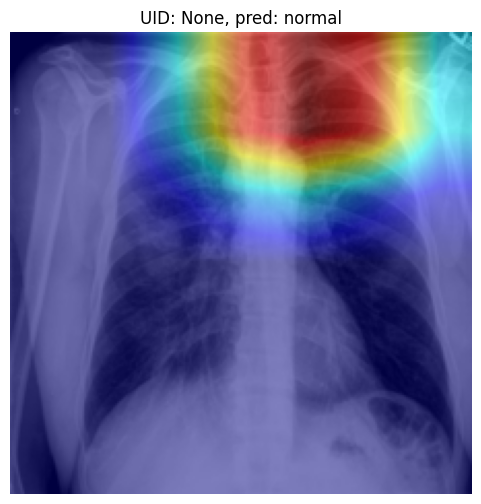

In [74]:
rgb_img = img[0].permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
vis = show_cam_on_image(rgb_img, cam_map, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.title(f"UID: {sample.get('uid')}, pred: {common_labels[pred_class]}")
plt.axis('off')

In [61]:
model.eval()

# Правильный target_layers:
target_layers = [model.backbone.features[-1]]  # последний сверточный блок DenseNet :contentReference[oaicite:3]{index=3}

gradcam = GradCAM(model=model.backbone, target_layers=target_layers)

# Получаем один образец из валидации
# sample = next(iter(test_ds))

# ИЛИ получаем случайный пример из валидации
idx = random.randint(0, len(test_ds) - 1)
sample = test_ds[idx]
img, labels = sample['img_f'], sample.get('labels', None)
print("Chosen sample UID:", sample.get('uid'))

img = sample['img_f'].unsqueeze(0).cuda()

# Передаём цель через targets в виде списка
targets = [ClassifierOutputTarget(pred_class)]

# # Получаем предсказания
# with torch.no_grad():
#     logits = model(img)
# probs = torch.sigmoid(logits).cpu().numpy()[0]
# pred_class = int(np.argmax(probs))

# Генерация CAM
grayscale_cam = gradcam(input_tensor=img, targets=targets)
cam_map = grayscale_cam[0]  # HxW канва

# Нормализуем изображение для наложения
rgb_img = img[0].permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

Chosen sample UID: None


(-0.5, 223.5, 223.5, -0.5)

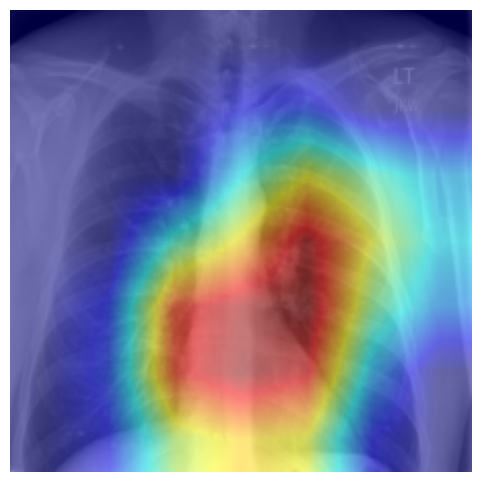

In [69]:
vis = show_cam_on_image(rgb_img, cam_map, use_rgb=True)

plt.figure(figsize=(6,6))
plt.imshow(vis)
plt.axis('off')